### Setup

In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
test_share=0.2 
cv_folds=10
cv_reps=50
cv_count=cv_folds*cv_reps
rs=1 # random_state for reproducibility

##### Example Dataset

In [4]:
X, y, w = make_regression(n_samples=250,
                          n_features=15, # x variables generated and returned 
                          n_informative=8, # x variables included in the actual model of y
                          effective_rank=5, # make less than n_informative for multicollinearity
                          coef=True,
                          noise=5,
                          random_state=rs,
                          bias=1.5)

In [5]:
# add interaction terms

In [6]:
if test_share:
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_share, random_state=rs)
else:
    X_train, X_test, y_train, y_test = (X, None, y, None)

### Model Selection

In [7]:
# for elastic_net, add custom transformer to change data to Fortran contiguous if not?
linear_regression=make_pipeline(StandardScaler(),LinearRegression())
elastic_net = make_pipeline(StandardScaler(), ElasticNetCV())
linear_svr = make_pipeline(StandardScaler(),GridSearchCV(LinearSVR(random_state=rs,tol=1e-3,max_iter=5000),n_jobs=1,param_grid={'C':np.linspace(-1,4,8)}))
model_dict={'elastic-net':elastic_net,'linear-svr':linear_svr, 'linear-regression':linear_regression}

In [8]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
cv=RepeatedKFold(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs) # define separately to ensure same cv data used for each model
# allow/generate water quality thresholds for stratified kfold sub-sampling to ensure cross-validation folds have full range of water quality

In [9]:
cv_results={model_name:cross_validate(model, X_train, y_train, return_estimator=True, scoring=scorer_list, cv=cv)
            for model_name,model in model_dict.items()}
# replace with a loop in order to save the residuals for the graph?

### graphs and table to summarize results

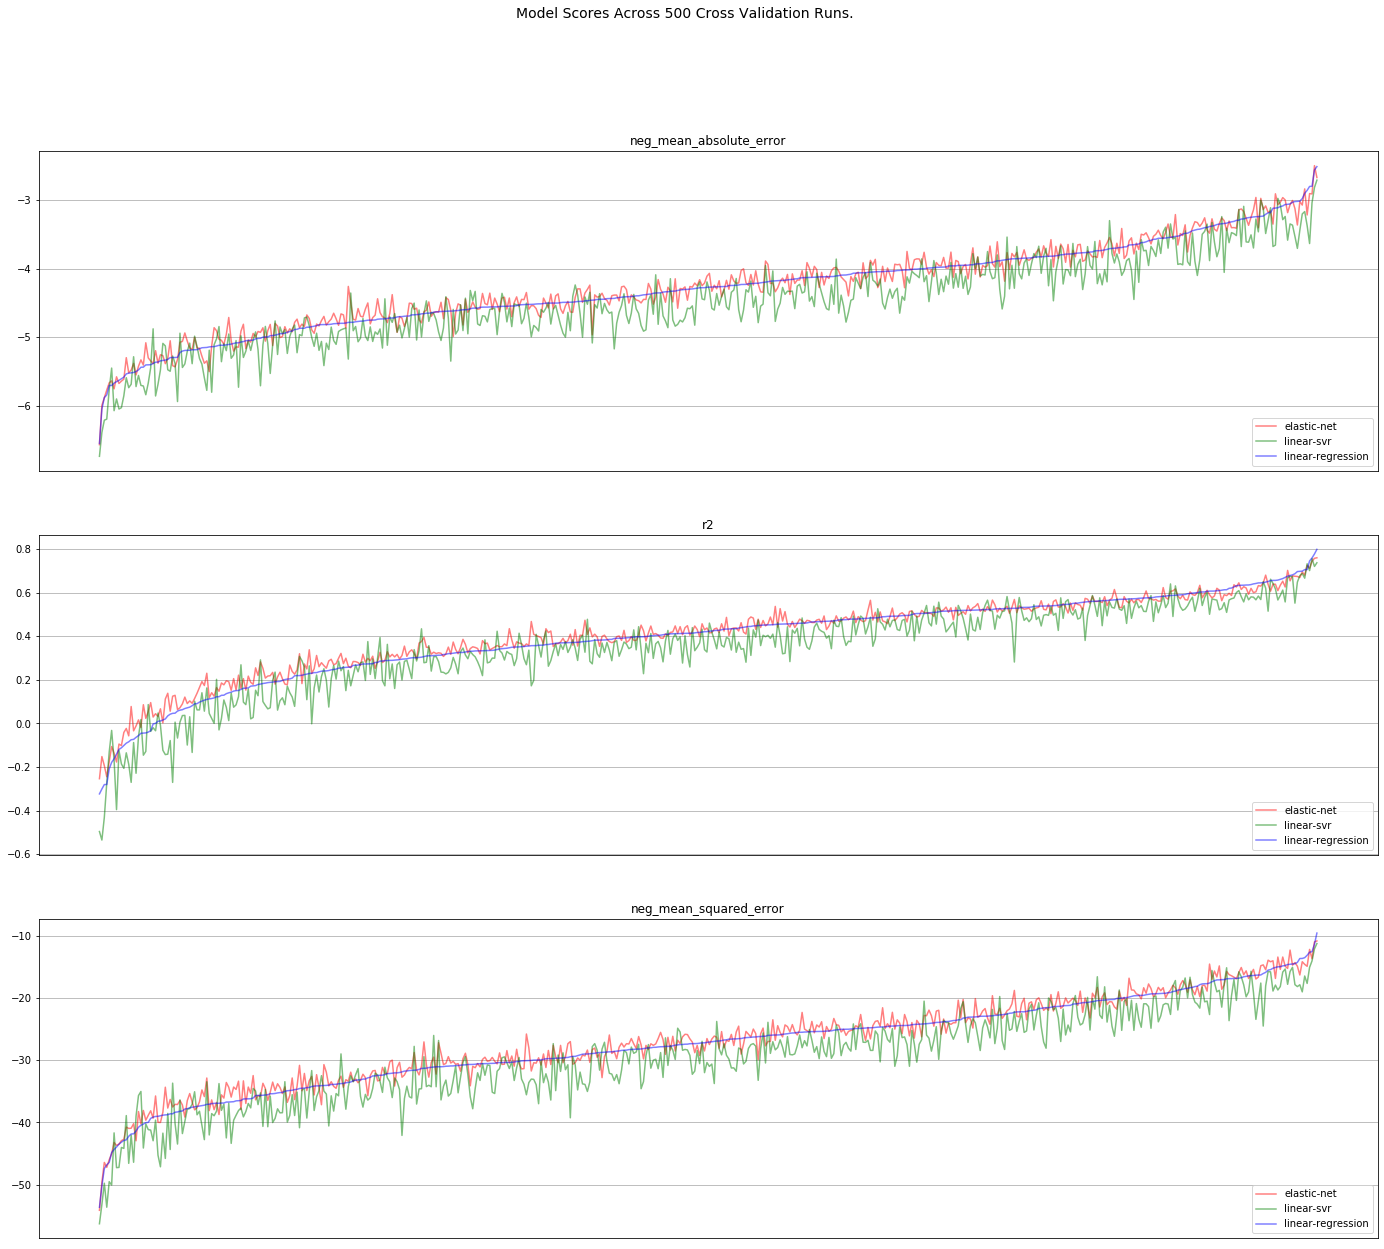

In [10]:
cv_score_dict={}
for idx,(model_name,result) in enumerate(cv_results.items()):
    cv_estimators=result['estimator']
    #cv_estimator_names=[str(type(est)).split(".")[-1][:-2] for est in cv_estimators
    cv_score_dict[model_name]={scorer:result[f'test_{scorer}'] for scorer in scorer_list} # fstring bc how cross_validate stores list of metrics
colors = ['r', 'g', 'b']    
fig=plt.figure(figsize=[24,20])
plt.suptitle(f"Model Scores Across {cv_count} Cross Validation Runs. ", fontsize=14)
s_count=len(scorer_list)
xidx=np.arange(cv_count) # place holder for scatterplot

for s_idx, scorer in enumerate(scorer_list):
    ax=fig.add_subplot(f'{s_count}1{s_idx}')
    #ax.set_xlabel('estimator')
    #ax.set_ylabel(scorer)
    ax.set_title(scorer)
    sortidx=np.argsort(cv_score_dict['linear-regression'][scorer])
    for m_idx,model_name in enumerate(cv_results.keys()):
        ax.plot(xidx,cv_score_dict[model_name][scorer][sortidx],color=colors[m_idx],alpha=0.5,label=model_name )
    ax.grid(True)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_visible(False)
    ax.legend(loc=4)

    

In [11]:
# create a similar plot showing residuals from the cv models for each value of y. 
# needs to be scatterplot since there will be (folds-1)*repeats predictions of each value of y.

-----------------------------
### User chooses elastic net!


In [15]:

final_model=elastic_net
final_model.fit(X_train,y_train)
if test_share:
    y_test_hat=final_model.predict(X_test)
    print(mean_squared_error(y_test,y_test_hat))
else:


    
    

30.728708469508444


In [17]:
final_model=linear_svr
final_model.fit(X_train,y_train)
y_test_hat=final_model.predict(X_test)
print(mean_squared_error(y_test,y_test_hat))

30.274680251054228
